In [767]:
import pandas as pd;
import numpy as np;

covid = pd.read_csv('./models/google_new.csv');

In [768]:
#List of all countries in dataset
countries = covid['country'].unique()

#dict with populations to fill
population = {'Argentina' : 44490000, 'Australia' : 24990000, 'Brazil' : 209500000, 'Canada' : 37590000, 'Germany' : 83020000, 'Spain' : 46940000, 
              'France' : 66990000, 'United Kingdom' : 66650000, 'Indonesia' : 267700000, 'India' : 1353000000, 'Italy' : 60360000, 'Japan' : 126500000, 
              'South Korea' : 51640000, 'Mexico' : 126200000, 'Saudi Arabia' : 33700000, 'Sweden' : 10230000, 'Turkey' : 82000000, 'US' : 328200000, 
              'South Africa' : 57780000}

#passed days column
covid['date']= pd.to_datetime(covid.date)
for country in countries:
    covid.loc[covid['country'] == country, 'population'] = population[country];
    covid.loc[:, 'cases_per_thousand'] = covid['total_cases']/(covid['population']/1000000.0);
    country_rows = covid[covid['country'] == country]
    covid.loc[covid['country'] == country, 'passed_days'] = (country_rows['date'] - country_rows.iloc[0]['date']).dt.days
    
#cases in the previous day
covid['cases_last_day'] = covid['cases_per_thousand'].shift(1)
covid['cases_last_day'].fillna(0, inplace=True)
covid[covid['cases_last_day'] < 0] = 0

In [769]:
%matplotlib inline
import matplotlib.pyplot as plt;
import seaborn as sb;

# train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
covid['country'] = le.fit_transform(covid['country'])

# Define country to use by excluding it from training/testing dataset
testing = covid.drop(covid.loc[covid.country== 18].index);

testing = testing.drop(columns=['fatalities', 'date', 'iso', 'population', 'total_cases'])
testing.reset_index(drop=True, inplace=True)

train , test = train_test_split(testing, test_size=0.3, random_state=4, stratify=testing['country'])

x_train = train.drop('cases_per_thousand', axis=1)
y_train = train['cases_per_thousand']

x_test = test.drop('cases_per_thousand', axis = 1)
y_test = test['cases_per_thousand']

RMSE value for k=  1 is: 36.79836568429459
RMSE value for k=  2 is: 157.7450064253104
RMSE value for k=  3 is: 157.69676805166637
RMSE value for k=  4 is: 142.34396052314253
RMSE value for k=  5 is: 136.99499123844998
RMSE value for k=  6 is: 129.06622737480856
RMSE value for k=  7 is: 124.07532389248624
RMSE value for k=  8 is: 125.28484833017167
RMSE value for k=  9 is: 122.77654242916502
RMSE value for k=  10 is: 124.20166212482633
RMSE value for k=  11 is: 124.65258105451318
RMSE value for k=  12 is: 124.29331125661275
RMSE value for k=  13 is: 125.841295013967
RMSE value for k=  14 is: 132.40807672518952
RMSE value for k=  15 is: 144.6798743680537
RMSE value for k=  16 is: 147.4796345093825
RMSE value for k=  17 is: 151.4717787558658
RMSE value for k=  18 is: 153.4906552752487
RMSE value for k=  19 is: 160.1768025007278
RMSE value for k=  20 is: 165.74437494020367
Best K value: 1


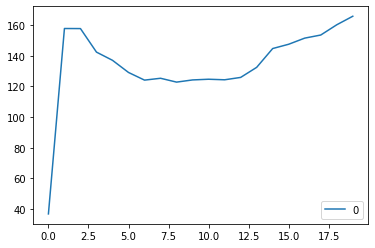

In [770]:
# best K value
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

#Root Mean Squared Error 
rmse_val = []
final_k = 0
error = 100000.0

for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    cur_error = sqrt(mean_squared_error(y_test,pred))
    if(cur_error < error):
        error=cur_error
        final_k = K
        
    rmse_val.append(cur_error)
    print('RMSE value for k= ' , K , 'is:', cur_error)
    
curve = pd.DataFrame(rmse_val)
curve.plot()
print('Best K value:', final_k)

In [771]:
# this is another (better) way of getting the right k value
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13]}

knn = neighbors.KNeighborsRegressor()
kfold = KFold(n_splits=10, random_state = 7, shuffle=True)

model = GridSearchCV(knn, params, cv=kfold, scoring='r2')
model.fit(x_train,y_train)
print(model.score(x_test, y_test))
print('Best parameters: {}'.format(model.best_params_))

0.8777869326457287
Best parameters: {'n_neighbors': 2}


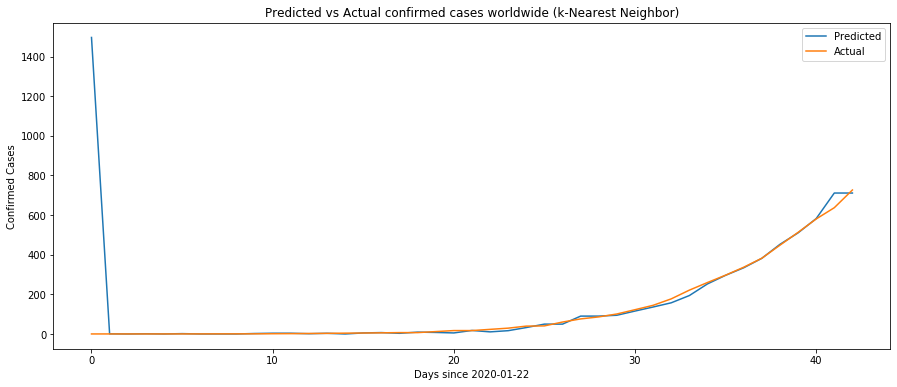

In [772]:
ct = covid.loc[covid['country'] == 18]
ct= ct.drop(columns=['fatalities', 'date', 'iso', 'population', 'total_cases'])

# preserve solution
solution = ct
ct = ct.drop(['cases_per_thousand'], axis=1)

predict = model.predict(ct)
ct['cases_per_thousand'] = predict
# ct

fig = plt.figure(figsize=(15,6))
sb.lineplot(x='passed_days', y='cases_per_thousand', label='Predicted', data=ct.groupby(['passed_days'], as_index=False)['cases_per_thousand'].sum())
ax = sb.lineplot(x='passed_days', y='cases_per_thousand', label='Actual', data=solution.groupby(['passed_days'], as_index=False)['cases_per_thousand'].sum())
ax = ax.set(xlabel='Days since 2020-01-22', ylabel='Confirmed Cases', title='Predicted vs Actual confirmed cases worldwide (k-Nearest Neighbor)')